**Классификация изображений с помощью сверточных нейронных сетей**

В данном задании Вам необходимо разработать архитектуру сверточной ИНС, обеспечивающую наибольшую точность при ограничении на количество операций (FLOPs <= 0.707e6).
Заготовка кода для выполнения задания приведена выше. Вашей задачей будет заполнить пропущеные места, которые отмечены ключевым словом *None*.
Необходимая точность (accuracy) сети на датасете CIFAR100 - 30%
Желаемая точность (accuracy) сети на датасете CIFAR100 - 45%

In [ ]:
!pip install keras-flops

In [2]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_flops import get_flops

In [3]:
# Глобальные константы
CLASSES       = 100
BATCH_SIZE    = 128
LEARNING_RATE = 1e-2

In [4]:
# Выполните загрузку модели
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [5]:
# Преобразуйте метки классов в one_hot формат
y_train = (y_train == np.arange(CLASSES)).astype(np.float32)
y_val = (y_val == np.arange(CLASSES)).astype(np.float32)

In [6]:
print(y_val.shape)

(10000, 100)


In [7]:
# убедитесь, что данная ячейка выполняется без ошибок
assert X_train.shape == (50000, 32, 32, 3)
assert X_val.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 100)
assert y_val.shape == (10000, 100)

In [ ]:
# Задайте архитектуру модели
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=[32,32,3]),
    tf.keras.layers.SeparableConv2D(16, 3, padding='valid'),
    tf.keras.layers.MaxPool2D(pool_size = (3, 3), strides=2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(CLASSES),
    tf.keras.layers.Activation('softmax')
])

In [9]:
# вычисление количества операций
flops = get_flops(model, batch_size=1)
print(f"FLOPs: {(flops / 1e6):.4f}e6")


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

2023-01-25 15:03:04.341225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:03:04.341687: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-25 15:03:04.341866: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-25 15:03:04.342433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:03:04.342978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:03:04.343353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

le:
node name | # float_ops
_TFProfRoot (--/339.82k flops)
  sequential/dense/MatMul (156.80k/156.80k flops)
  sequential/separable_conv2d/separable_conv2d (86.40k/135.00k flops)
    sequential/separable_conv2d/separable_conv2d/depthwise (48.60k/48.60k flops)
  sequential/max_pooling2d/MaxPool (28.22k/28.22k flops)
  sequential/separable_conv2d/BiasAdd (14.40k/14.40k flops)
  sequential/max_pooling2d_1/MaxPool (3.14k/3.14k flops)
  sequential/batch_normalization/FusedBatchNormV3 (1.66k/1.66k flops)
  sequential/activation_1/Softmax (500/500 flops)
  sequential/dense/BiasAdd (100/100 flops)

======================End of Report==========================


In [10]:
# вывод краткой информации о модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 30, 30, 16)        91        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 16)          64        
_________________________________________________________________
activation (Activation)      (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               7

In [11]:
# параметры данной ячейки могут быть изменены для получения более высокой точности
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE, decay_steps=1000, decay_rate=0.3)
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
# обучения модели
hist = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath="{epoch:02d}-{val_accuracy:.2f}.hdf5", save_best_only=True),
        
    ],
    use_multiprocessing=True,
    workers=8,
    epochs=40
)

Epoch 1/40
391/391 [==============================] - 3s 8ms/step - loss: 1.1440 - accuracy: 0.6072 - val_loss: 1.2088 - val_accuracy: 0.5803
Epoch 2/40
391/391 [==============================] - 3s 8ms/step - loss: 1.1430 - accuracy: 0.6089 - val_loss: 1.2083 - val_accuracy: 0.5804
Epoch 3/40
391/391 [==============================] - 3s 9ms/step - loss: 1.1424 - accuracy: 0.6087 - val_loss: 1.2085 - val_accuracy: 0.5824
Epoch 4/40
391/391 [==============================] - 3s 8ms/step - loss: 1.1413 - accuracy: 0.6089 - val_loss: 1.2081 - val_accuracy: 0.5816
Epoch 5/40
391/391 [==============================] - 3s 8ms/step - loss: 1.1418 - accuracy: 0.6088 - val_loss: 1.2080 - val_accuracy: 0.5820
Epoch 6/40
391/391 [==============================] - 3s 8ms/step - loss: 1.1412 - accuracy: 0.6085 - val_loss: 1.2079 - val_accuracy: 0.5824
Epoch 7/40
391/391 [==============================] - 3s 8ms/step - loss: 1.1410 - accuracy: 0.6077 - val_loss: 1.2081 - val_accuracy: 0.5820
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


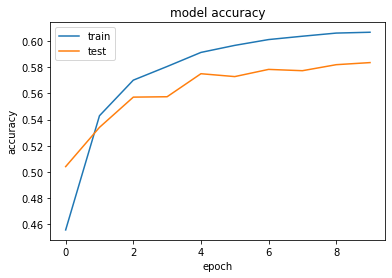

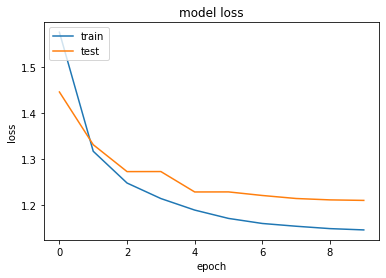

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()